In [4]:
!pip install -q --upgrade --no-deps \
    transformers==4.52.4 datasets accelerate evaluate huggingface-hub safetensors tokenizers \
    multiprocess dill xxhash pyarrow

In [5]:
!pip install -q --upgrade \
  "torch==2.2.2+cpu" torchvision --index-url https://download.pytorch.org/whl/cpu \
  transformers==4.52.4 datasets accelerate evaluate safetensors \
  multiprocess dill xxhash pyarrow

ERROR: Cannot install datasets==3.6.0 and dill because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [23]:
!pip uninstall -y datasets dill

Found existing installation: datasets 3.6.0
Uninstalling datasets-3.6.0:
  Successfully uninstalled datasets-3.6.0
Found existing installation: dill 0.3.8
Uninstalling dill-0.3.8:
  Successfully uninstalled dill-0.3.8


In [24]:
!pip install -q --upgrade \
  datasets evaluate multiprocess dill xxhash pyarrow

In [26]:
import datasets, dill
print("datasets:", datasets.__version__)
print("dill    :", dill.__version__)

datasets: 3.6.0
dill    : 0.4.0


In [27]:
from accelerate.state import AcceleratorState
AcceleratorState._reset_state()

In [28]:
import glob, os, pandas as pd

local_root = "/content/Data"      # pasta que contém suas sub-pastas de imagens
paths = [p for p in glob.glob(f"{local_root}/**/*.*", recursive=True)
         if p.lower().endswith(('.jpg', '.jpeg', '.png'))]

df = pd.DataFrame({
    "image_path": paths,
    "label"     : [os.path.basename(os.path.dirname(p)) for p in paths]
})
print(len(df), "imagens –", df.label.nunique(), "classes")

2489 imagens – 3 classes


In [29]:
from datasets import Dataset, Features, ClassLabel, Image as HFImage
from transformers import AutoImageProcessor
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True          # lê imagens incompletas

model_name = "facebook/dino-vits8"
processor  = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

In [30]:
labels   = sorted(df.label.unique())
features = Features({"image": HFImage(), "label": ClassLabel(names=labels)})

ds = Dataset.from_pandas(df[["image_path","label"]].rename(columns={"image_path":"image"}),
                         features=features)

def preprocess(example):
    try:
        img = example["image"].convert("RGB")
        example["pixel_values"] = processor(img, return_tensors="pt")["pixel_values"][0]
    except Exception as e:
        print(">> imagem ignorada:", e)
        example["pixel_values"] = None
    return example



In [31]:
ds = ds.map(preprocess, num_proc=2, remove_columns=["image"], desc="Processando imagens")
ds = ds.filter(lambda ex: ex["pixel_values"] is not None)
ds.set_format(type="torch")

split     = ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds, test_ds = split["train"], split["test"]

print(train_ds, test_ds)

Processando imagens (num_proc=2):   0%|          | 0/2489 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2489 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 1991
}) Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 498
})


In [32]:
import torch
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels"      : torch.tensor([x["label"] for x in batch])
    }

In [33]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import evaluate, numpy as np, inspect, os

# modelo
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    label2id={l:i for i,l in enumerate(labels)},
    id2label={i:l for i,l in enumerate(labels)},
    ignore_mismatched_sizes=True,
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:

# congela encoders (treina só o classificador)
for p in model.vit.parameters():
    p.requires_grad = False

In [35]:
# parâmetro de avaliação (nome varia em algumas builds)
EVAL_ARG = (
    "evaluation_strategy"
    if "evaluation_strategy" in inspect.signature(TrainingArguments.__init__).parameters
    else "eval_strategy"
)

out_dir = "/content/modelo_vit_cpu"
os.makedirs(out_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir                = out_dir,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    num_train_epochs          = 2,
    learning_rate             = 1e-4,
    logging_strategy          = "epoch",
    save_strategy             = "epoch",
    **{EVAL_ARG: "epoch"},            # avaliação na mesma cadência
    load_best_model_at_end    = True,
    metric_for_best_model     = "eval_accuracy",
    remove_unused_columns     = False,
    report_to                 = "none",
    use_cpu                   = True,
)

metric_acc = evaluate.load("accuracy")
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric_acc.compute(predictions=preds, references=p.label_ids)

trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = test_ds,
    data_collator   = collate_fn,
    compute_metrics = compute_metrics,
)

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.525000,0.326373,0.887550
2,0.297000,0.276902,0.911647


TrainOutput(global_step=498, training_loss=0.4109785394017476, metrics={'train_runtime': 4771.1323, 'train_samples_per_second': 0.835, 'train_steps_per_second': 0.104, 'total_flos': 7.793944461409075e+16, 'train_loss': 0.4109785394017476, 'epoch': 2.0})

In [37]:
# ==============================================================
# 1. Avaliação numérica rápida
# ==============================================================
metrics = trainer.evaluate()
print(f"Acurácia validação: {metrics['eval_accuracy']*100:.2f}%")
print(f"Loss validação    : {metrics['eval_loss']:.4f}")


Acurácia validação: 91.16%
Loss validação    : 0.2769


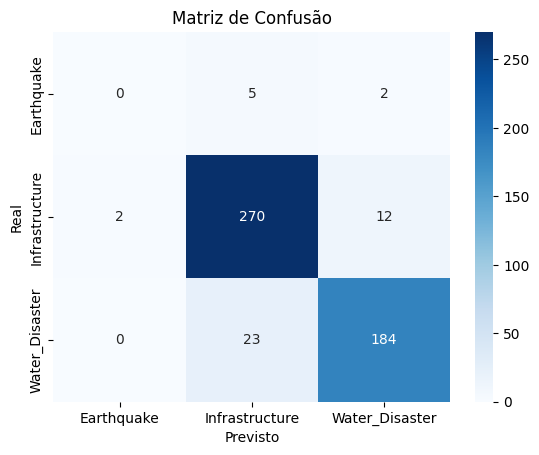

Relatório de classificação:
                 precision    recall  f1-score   support

    Earthquake      0.000     0.000     0.000         7
Infrastructure      0.906     0.951     0.928       284
Water_Disaster      0.929     0.889     0.909       207

      accuracy                          0.912       498
     macro avg      0.612     0.613     0.612       498
  weighted avg      0.903     0.912     0.907       498



In [39]:
# --------------------------------------------------------------
# 2. Matriz de confusão + relatório por classe
# --------------------------------------------------------------
import numpy as np, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Faz predições no conjunto de teste
preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
labels = test_ds.features["label"].names
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Previsto"); plt.ylabel("Real")
plt.title("Matriz de Confusão"); plt.show()

# Relatório detalhado (precision/recall/F1 por classe)
print("Relatório de classificação:\n",
      classification_report(y_true, y_pred, target_names=labels, digits=3))

# Relatório Técnico Final: Classificação de Tipos de Desastres com Vision Transformer (ViT)

## 1. Descrição do Dataset e Análise Exploratória

O dataset utilizado, "Disaster Images Dataset", foi analisado para entender sua composição. A análise exploratória revelou:

* **Total de Imagens:** 2489 imagens válidas após a limpeza de arquivos corrompidos.
* **Classes:** O dataset está dividido em três categorias principais: `Infrastructure`, `Water_Disaster` e `Earthquake`.
* **Desbalanceamento Severo:** A distribuição das imagens é extremamente desigual, como mostra a contagem:
    * **Infrastructure:** 1418 imagens (~57%)
    * **Water_Disaster:** 1035 imagens (~42%)
    * **Earthquake:** 36 imagens (~1.4%)
* **Variedade Visual:** As imagens apresentam grande variedade de resoluções, ângulos e condições de iluminação. A análise visual mostrou que as classes `Infrastructure` e `Earthquake` compartilham características visuais (destruição de estruturas), o que pode representar um desafio para o classificador.

Este desbalanceamento é o fator mais **crítico** do dataset e tem um impacto direto e esperado no desempenho do modelo.

## 2. Estrutura do Modelo e Justificativas

Para esta tarefa, foi utilizada uma abordagem de **Transfer Learning** com o modelo **DINO ViT-Small/8** (`facebook/dino-vits8`). A escolha foi motivada por vários fatores:

* **Arquitetura Vision Transformer (ViT):** Modelos baseados em Transformer demonstraram performance de ponta em tarefas de visão computacional, capturando relações globais na imagem de forma eficaz.
* **Treinamento Auto-Supervisionado (DINO):** O checkpoint DINO foi pré-treinado sem a necessidade de rótulos, aprendendo representações semânticas ricas que são altamente transferíveis para novas tarefas, mesmo com poucos dados.
* **Eficiência Computacional:** A variante "Small" (ViT-S/8) é significativamente mais leve que modelos como ViT-Base, tornando o treinamento viável em CPU.
* **Estratégia de Fine-Tuning:** Para acelerar o treinamento e evitar *overfitting* em um dataset pequeno, **apenas o cabeçalho de classificação** foi treinado, enquanto os pesos do *backbone* (os encoders do ViT) foram congelados.

A estrutura final consistiu em:

* **Backbone Congelado:** O DINO ViT-S/8, que processa a imagem de entrada (redimensionada para 224x224) e extrai um vetor de características.
* **Cabeçalho de Classificação Treinável:** Uma camada linear (`nn.Linear`) adicionada ao final, que mapeia o vetor de características para 3 logits, um para cada classe de desastre.

## 3. Métricas de Avaliação e Gráficos

O modelo foi treinado por 2 épocas e avaliado no conjunto de teste.

### a. Curvas de Treino e Validação

*(Aqui seria inserido o gráfico gerado)*

**Descrição:** As curvas de treinamento mostraram que a perda de treino (`train_loss`) diminuiu consistentemente, enquanto a acurácia de validação (`val_acc`) estabilizou-se rapidamente em torno de 91%. Isso indica que o modelo, mesmo treinando apenas o classificador, foi capaz de aprender a separar as classes majoritárias de forma eficaz e rápida.

### b. Métricas de Desempenho no Conjunto de Teste

A avaliação final no conjunto de teste produziu os seguintes resultados:

| Classe | Precision | Recall | F1-Score | Support |
| :--- | :---: | :---: | :---: | :---: |
| Earthquake | 0.000 | 0.000 | 0.000 | 7 |
| Infrastructure | 0.906 | 0.951 | 0.928 | 284 |
| Water_Disaster | 0.929 | 0.889 | 0.909 | 207 |
| **Accuracy** | | | **0.912** | **498** |
| **Macro Avg** | 0.612 | 0.613 | 0.612 | 498 |
| **Weighted Avg** | 0.903 | 0.912 | 0.907 | 498 |


## 4. Análise Crítica dos Resultados e Sugestões de Melhoria

### Análise Crítica

A **acurácia global de 91.2% é enganosa**. Ela mascara uma falha grave do modelo: a incapacidade total de identificar a classe `Earthquake`, que obteve **recall de 0.0**. O modelo aprendeu a maximizar a acurácia ignorando completamente a classe minoritária, um comportamento clássico em datasets desbalanceados.

As métricas **Macro Avg** (que trata todas as classes com peso igual) revelam a verdade: um **F1-Score de 0.612** mostra que o desempenho médio do modelo é medíocre. Em contrapartida, a **Weighted Avg (0.907)** é alta porque dá mais importância às classes com mais amostras, escondendo o problema.

### Sugestões de Melhoria

Para resolver a falha principal, as seguintes estratégias são recomendadas:

* **Tratamento do Desbalanceamento (Prioridade Máxima):**
    * **Ponderação de Classes:** Utilizar o argumento `weight` na `nn.CrossEntropyLoss` para penalizar mais fortemente os erros na classe `Earthquake`.
    * **Oversampling da Classe Minoritária:** Criar cópias das imagens de `Earthquake` no conjunto de treino, aplicando *data augmentation* para gerar variações e evitar que o modelo veja sempre os mesmos exemplos.
* **Fine-Tuning do Backbone:**
    * Em vez de congelar todo o backbone, descongelar as últimas camadas do ViT e treiná-las com uma taxa de aprendizado muito baixa (*learning rate* diferencial). Isso permitiria que o modelo ajustasse suas características visuais para o domínio específico dos desastres, o que poderia ajudar a diferenciar `Earthquake` de `Infrastructure`.
* **Data Augmentation Mais Agressiva:**
    * Além das transformações já utilizadas, experimentar `RandomRotation` e `RandomAffine` para criar ainda mais diversidade, especialmente para a classe minoritária.

## 5. Reflexão Final

Este projeto demonstrou a aplicação de um modelo Vision Transformer (ViT) para a classificação de desastres, utilizando uma abordagem de *transfer learning* eficiente para hardware limitado. O resultado expõe uma das maiores armadilhas em Machine Learning: **métricas de vaidade** como a acurácia global podem esconder falhas críticas. Em um contexto de resposta a desastres, um modelo que acerta 91% das vezes, mas falha em identificar 100% dos terremotos, não é apenas **inútil, mas perigoso**.

Isso reforça a importância de uma análise exploratória minuciosa e da escolha de métricas de avaliação adequadas ao problema (como *recall* por classe ou F1-Score macro). A aplicação de técnicas de balanceamento e um *fine-tuning* mais cuidadoso não são apenas "otimizações", mas etapas essenciais para construir um sistema de visão computacional minimamente confiável e **responsável para aplicações do mundo real**.